In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("E:/dataset/pro/autograd/autograd")  # or the correct path to your project root

from engine import Value
from nn import Neuron, Layer, MLP

In [23]:
# Set random seeds for reproducibility
np.random.seed(1337)
random.seed(1337)

STEP 1: Creating Dataset
Dataset shape: (100, 2)
Number of samples: 100
Labels: [-1  1]


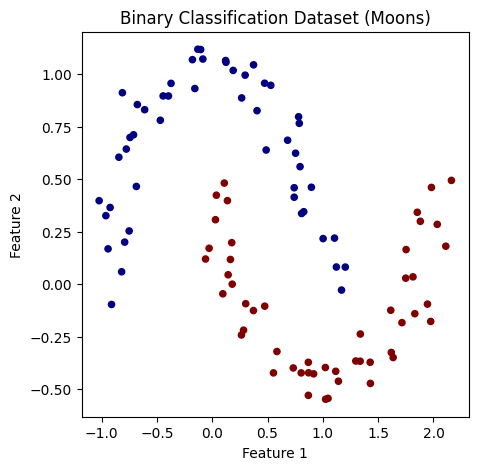

In [24]:
print("=" * 60)
print("STEP 1: Creating Dataset")
print("=" * 60)

from sklearn.datasets import make_moons, make_blobs

# Generate a binary classification dataset with moon-shaped clusters
dataset_X, dataset_y = make_moons(n_samples=100, noise=0.1)

# Convert labels from {0, 1} to {-1, 1} for SVM-style loss
dataset_y = dataset_y * 2 - 1

print(f"Dataset shape: {dataset_X.shape}")
print(f"Number of samples: {len(dataset_y)}")
print(f"Labels: {np.unique(dataset_y)}")

# Visualize the dataset in 2D
plt.figure(figsize=(5, 5))
plt.scatter(dataset_X[:, 0], dataset_X[:, 1], c=dataset_y, s=20, cmap='jet')
plt.title('Binary Classification Dataset (Moons)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [25]:
print("\n" + "=" * 60)
print("STEP 2: Initializing Neural Network")
print("=" * 60)

# Create a 2-layer neural network: 2 inputs -> 16 hidden -> 16 hidden -> 1 output
neural_network = MLP(2, [16, 16, 1])

print(f"Model architecture: {neural_network}")
print(f"Total number of parameters: {len(neural_network.parameters())}")



STEP 2: Initializing Neural Network
Model architecture: MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Total number of parameters: 337


In [26]:
def compute_loss(batch_size=None):
    """
    Compute the loss and accuracy for the model.
    
    Args:
        batch_size: If None, use full dataset. Otherwise, sample a mini-batch.
        
    Returns:
        tuple: (total_loss, accuracy)
    """
    # Create mini-batch or use full dataset
    if batch_size is None:
        batch_X, batch_y = dataset_X, dataset_y
    else:
        # Randomly sample indices for mini-batch
        random_indices = np.random.permutation(dataset_X.shape[0])[:batch_size]
        batch_X, batch_y = dataset_X[random_indices], dataset_y[random_indices]
    
    # Convert numpy arrays to Value objects for autograd
    inputs = [list(map(Value, sample_row)) for sample_row in batch_X]
    
    # Forward pass: compute predictions for all samples
    predictions = list(map(neural_network, inputs))
    
    # SVM "max-margin" loss: max(0, 1 - y * prediction)
    # This encourages correct predictions with margin > 1
    individual_losses = [
        (1 + -true_label * prediction).relu() 
        for true_label, prediction in zip(batch_y, predictions)
    ]
    data_loss = sum(individual_losses) * (1.0 / len(individual_losses))
    
    # L2 regularization: penalize large weights to prevent overfitting
    regularization_strength = 1e-4
    reg_loss = regularization_strength * sum(
        (param * param for param in neural_network.parameters())
    )
    total_loss = data_loss + reg_loss
    
    # Calculate accuracy: percentage of correct predictions
    correct_predictions = [
        (true_label > 0) == (prediction.data > 0) 
        for true_label, prediction in zip(batch_y, predictions)
    ]
    accuracy = sum(correct_predictions) / len(correct_predictions)
    
    return total_loss, accuracy


# Test initial loss and accuracy
print("\n" + "=" * 60)
print("STEP 3: Initial Performance")
print("=" * 60)

initial_loss, initial_accuracy = compute_loss()
print(f"Initial loss: {initial_loss.data:.4f}")
print(f"Initial accuracy: {initial_accuracy * 100:.2f}%")


STEP 3: Initial Performance
Initial loss: 0.8958
Initial accuracy: 50.00%


In [27]:

print("\n" + "=" * 60)
print("STEP 4: Training Neural Network")
print("=" * 60)

num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass: compute loss and accuracy
    total_loss, accuracy = compute_loss()
    
    # Backward pass: compute gradients
    neural_network.zero_grad()  # Reset gradients to zero
    total_loss.backward()  # Backpropagation
    
    # Update parameters using Stochastic Gradient Descent (SGD)
    # Learning rate decays linearly from 1.0 to 0.1
    learning_rate = 1.0 - 0.9 * epoch / num_epochs
    for param in neural_network.parameters():
        param.data -= learning_rate * param.grad
    
    # Print progress every epoch
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d} | Loss: {total_loss.data:.4f} | Accuracy: {accuracy * 100:.2f}% | LR: {learning_rate:.4f}")


STEP 4: Training Neural Network
Epoch   0 | Loss: 0.8958 | Accuracy: 50.00% | LR: 1.0000
Epoch   1 | Loss: 1.7236 | Accuracy: 81.00% | LR: 0.9910
Epoch   2 | Loss: 0.7429 | Accuracy: 77.00% | LR: 0.9820
Epoch   3 | Loss: 0.7706 | Accuracy: 82.00% | LR: 0.9730
Epoch   4 | Loss: 0.3693 | Accuracy: 84.00% | LR: 0.9640
Epoch   5 | Loss: 0.3135 | Accuracy: 86.00% | LR: 0.9550
Epoch   6 | Loss: 0.2814 | Accuracy: 89.00% | LR: 0.9460
Epoch   7 | Loss: 0.2689 | Accuracy: 91.00% | LR: 0.9370
Epoch   8 | Loss: 0.2567 | Accuracy: 91.00% | LR: 0.9280
Epoch   9 | Loss: 0.2705 | Accuracy: 91.00% | LR: 0.9190
Epoch  10 | Loss: 0.2451 | Accuracy: 91.00% | LR: 0.9100
Epoch  11 | Loss: 0.2510 | Accuracy: 92.00% | LR: 0.9010
Epoch  12 | Loss: 0.2156 | Accuracy: 91.00% | LR: 0.8920
Epoch  13 | Loss: 0.2309 | Accuracy: 93.00% | LR: 0.8830
Epoch  14 | Loss: 0.2015 | Accuracy: 92.00% | LR: 0.8740
Epoch  15 | Loss: 0.2257 | Accuracy: 93.00% | LR: 0.8650
Epoch  16 | Loss: 0.1945 | Accuracy: 92.00% | LR: 0.856


STEP 5: Visualizing Decision Boundary


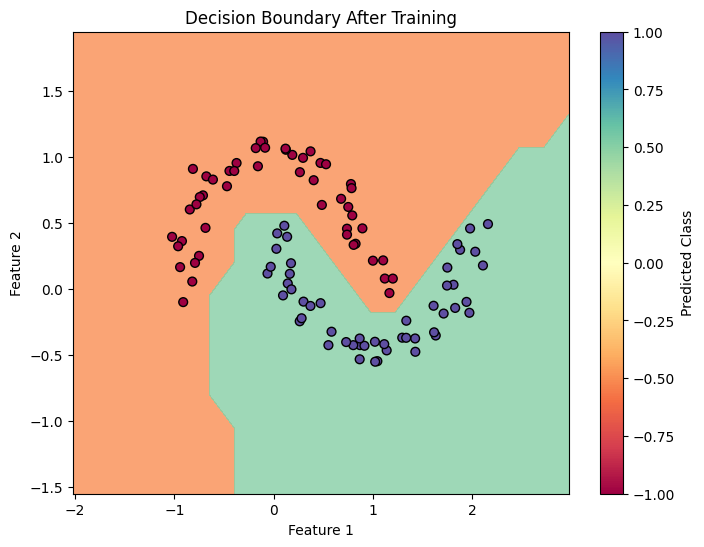


Training complete! Decision boundary visualized.


In [28]:
print("\n" + "=" * 60)
print("STEP 5: Visualizing Decision Boundary")
print("=" * 60)

# Create a mesh grid to evaluate the model at every point
grid_resolution = 0.25
x_min, x_max = dataset_X[:, 0].min() - 1, dataset_X[:, 0].max() + 1
y_min, y_max = dataset_X[:, 1].min() - 1, dataset_X[:, 1].max() + 1
mesh_xx, mesh_yy = np.meshgrid(
    np.arange(x_min, x_max, grid_resolution),
    np.arange(y_min, y_max, grid_resolution)
)

# Flatten the mesh grid and create input samples
mesh_points = np.c_[mesh_xx.ravel(), mesh_yy.ravel()]
mesh_inputs = [list(map(Value, point_row)) for point_row in mesh_points]

# Get predictions for all mesh points
mesh_predictions = list(map(neural_network, mesh_inputs))

# Convert predictions to binary decisions (positive or negative)
decision_values = np.array([prediction.data > 0 for prediction in mesh_predictions])
decision_values = decision_values.reshape(mesh_xx.shape)

# Plot the decision boundary
fig = plt.figure(figsize=(8, 6))
plt.contourf(mesh_xx, mesh_yy, decision_values, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(dataset_X[:, 0], dataset_X[:, 1], c=dataset_y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
plt.xlim(mesh_xx.min(), mesh_xx.max())
plt.ylim(mesh_yy.min(), mesh_yy.max())
plt.title('Decision Boundary After Training')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.show()

print("\nTraining complete! Decision boundary visualized.")
print("=" * 60)